In [1]:
import torch
import torchvision
import os

import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.io import read_image

from transformers import BeitForImageClassification, BeitConfig, BeitFeatureExtractor, Trainer, TrainingArguments
from PIL import Image

from tqdm import tqdm
from collections import defaultdict

In [2]:
# Check for GPU
device = ("cuda:0" if torch.cuda.is_available() else "cpu")

device

'cuda:0'

In [3]:
class food_train(Dataset):

    def __init__(self, labels_file, img_dir, extractor, transform = None):
        self.img_labels = pd.read_csv(labels_file, names=['img_name', 'label'], header=1)[:25000]
        self.img_dir = img_dir
        self.feature_extractor = extractor
        self.transform = transform
        
    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path)
        
        if self.transform:
            image = self.transform(image)
                
        features = self.feature_extractor(images=image)["pixel_values"][0]
        label = self.img_labels.iloc[idx, 1]       
            
        return features, label

In [4]:
class food_val(Dataset):

    def __init__(self, labels_file, img_dir, extractor, transform = None):
        self.img_labels = pd.read_csv(labels_file, names=['img_name', 'label'], header=1)[25000:]
        self.img_dir = img_dir
        self.feature_extractor = extractor
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path)
        
        features = self.feature_extractor(images=image)["pixel_values"][0]
        label = self.img_labels.iloc[idx, 1]       
        
        if self.transform:
            image = self.transform(image)
            
        return features, label

In [5]:
class food_test(Dataset):

    def __init__(self, img_dir, extractor, transform = None):
        self.img_dir = img_dir
        self.feature_extractor = extractor
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):
        file_name = os.listdir(self.img_dir)[idx]
        img_path = os.path.join(self.img_dir, file_name)
        image = Image.open(img_path)
        
        if self.transform:
            image = self.transform(image)
        
        features = self.feature_extractor(images=image)["pixel_values"][0]
        
        return file_name, features

In [6]:
img_dir = "../data/train_set/train_set"
labels = "../data/train_labels.csv"

# Resize image to match BEiT, convert to torch.float, normalize
transform = transforms.Compose(
                    [transforms.RandomApply(
                        [transforms.ColorJitter(),
                         transforms.CenterCrop(100),
                         transforms.Grayscale(3),
                         transforms.RandomAffine(180)]),
                     transforms.RandomHorizontalFlip()])

feature_extractor = BeitFeatureExtractor.from_pretrained("microsoft/beit-base-patch16-224")

# Create datasets
train_set = food_train(labels, img_dir, feature_extractor, transform = transform)
trainloader = DataLoader(train_set, batch_size=16, shuffle=True, num_workers=0)

val_set = food_val(labels, img_dir, feature_extractor)
valloader = DataLoader(val_set, batch_size=16, shuffle=True, num_workers=0)

len(train_set), len(val_set)

(25000, 5611)

In [17]:
test_set = food_test("../data/test_set/test_set", feature_extractor)
testloader = DataLoader(test_set, batch_size = 16)

len(test_set)

7653

In [8]:
# Load BEiT
beit = BeitForImageClassification.from_pretrained("microsoft/beit-base-patch16-224")

beit.classifier = torch.nn.Linear(768, 81)

D:\ProgramData\Anaconda3\envs\R + Python\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [9]:
# CrossEntropyLoss and SGD optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(beit.parameters(), lr = 0.001, momentum = 0.9)
# optimizer = optim.Adam(beit.parameters(), lr=0.00001)

In [10]:
len(trainloader.dataset)

25000

In [11]:
def train_loop(dataloader, model, criterion, optimizer):
    # Get size of dataset
    size = len(dataloader.dataset)
    # Train on GPU if available
    model = model.to(device)
    model.train()
    
    # Metadata
    stats = defaultdict(list)
    current_acc = 0
    max_acc = 0
    
    stats["epoch"].append(0)
    stats["loss"].append(8.7)
    stats["accuracy"].append(1.25)
    
    for epoch in range(25):
        for batch, (image, label) in enumerate(dataloader):
            # Compute prediction and loss
            image, label = image.to(device), label.to(device)            
            pred = model(image)
            loss = criterion(pred["logits"], label)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Print progress
            if batch % 200 == 0:
                loss, current = loss.item(), batch * len(image)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}] epoch: {epoch + 1}")
        
        # Print performance after current number of epochs
        print(f"Epoch: {epoch + 1}")
        current_acc, avg_loss = test_loop(valloader, model, criterion)
        
        if current_acc > max_acc:
            PATH = f'../../other_beit_optimal.pth'
            torch.save(beit.state_dict(), PATH)
            max_acc = current_acc
            
        # Store metadata
        stats["epoch"].append(epoch + 1)
        stats["accuracy"].append(current_acc)
        stats["loss"].append(avg_loss)
        
        # Plot progress
        fig, ax1 = plt.subplots()

        color = "tab:blue"
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("Loss", color=color)
        ax1.plot(stats["epoch"], stats["loss"], color=color)
        ax1.tick_params(axis="y", labelcolor=color)

        ax2 = ax1.twinx()

        color = "tab:orange"
        ax2.set_ylabel("Accuracy", color=color)
        ax2.plot(stats["epoch"], stats["accuracy"], color=color)
        ax2.tick_params(axis="y", labelcolor=color)
        plt.show()
    
    return stats


def test_loop(dataloader, model, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for image, label in dataloader:
            image, label = image.to(device), label.to(device)
            pred = model(image)
            test_loss += criterion(pred["logits"], label).item()
            correct += (pred["logits"].argmax(1) == label).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return (100 * correct), test_loss

loss: 4.487272  [    0/25000] epoch: 1
loss: 3.891391  [ 3200/25000] epoch: 1
loss: 4.426147  [ 6400/25000] epoch: 1
loss: 4.125735  [ 9600/25000] epoch: 1
loss: 4.301596  [12800/25000] epoch: 1
loss: 3.276731  [16000/25000] epoch: 1
loss: 3.207412  [19200/25000] epoch: 1
loss: 2.699229  [22400/25000] epoch: 1
Epoch: 1
Test Error: 
 Accuracy: 43.7%, Avg loss: 2.323954 



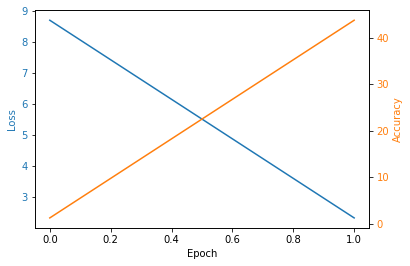

loss: 1.975922  [    0/25000] epoch: 2
loss: 2.565873  [ 3200/25000] epoch: 2
loss: 2.467401  [ 6400/25000] epoch: 2
loss: 2.035814  [ 9600/25000] epoch: 2
loss: 2.277274  [12800/25000] epoch: 2
loss: 1.615060  [16000/25000] epoch: 2
loss: 2.284310  [19200/25000] epoch: 2
loss: 2.721308  [22400/25000] epoch: 2
Epoch: 2
Test Error: 
 Accuracy: 63.9%, Avg loss: 1.405681 



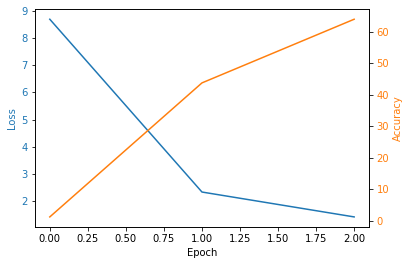

loss: 2.290102  [    0/25000] epoch: 3
loss: 2.078547  [ 3200/25000] epoch: 3
loss: 2.122418  [ 6400/25000] epoch: 3
loss: 1.377191  [ 9600/25000] epoch: 3
loss: 1.151258  [12800/25000] epoch: 3
loss: 2.256516  [16000/25000] epoch: 3
loss: 1.987684  [19200/25000] epoch: 3
loss: 2.070532  [22400/25000] epoch: 3
Epoch: 3
Test Error: 
 Accuracy: 67.4%, Avg loss: 1.248253 



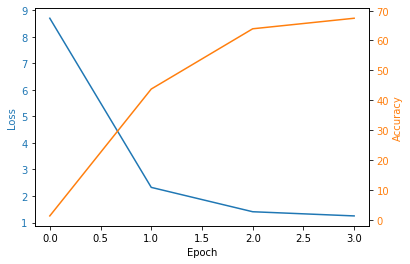

loss: 1.822064  [    0/25000] epoch: 4
loss: 1.970176  [ 3200/25000] epoch: 4
loss: 1.620590  [ 6400/25000] epoch: 4
loss: 1.653589  [ 9600/25000] epoch: 4
loss: 1.997754  [12800/25000] epoch: 4
loss: 1.939106  [16000/25000] epoch: 4
loss: 1.739242  [19200/25000] epoch: 4
loss: 1.791901  [22400/25000] epoch: 4
Epoch: 4
Test Error: 
 Accuracy: 68.2%, Avg loss: 1.226683 



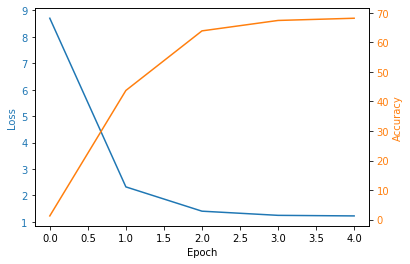

loss: 1.655221  [    0/25000] epoch: 5
loss: 1.862816  [ 3200/25000] epoch: 5
loss: 2.345499  [ 6400/25000] epoch: 5
loss: 1.753984  [ 9600/25000] epoch: 5
loss: 1.826301  [12800/25000] epoch: 5
loss: 1.686454  [16000/25000] epoch: 5
loss: 2.028600  [19200/25000] epoch: 5
loss: 1.283024  [22400/25000] epoch: 5
Epoch: 5
Test Error: 
 Accuracy: 68.3%, Avg loss: 1.218163 



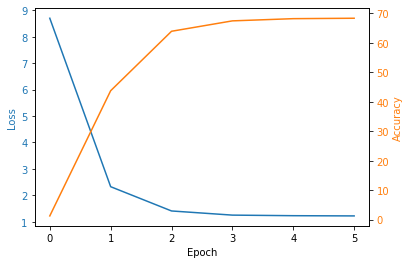

loss: 1.899561  [    0/25000] epoch: 6
loss: 1.192217  [ 3200/25000] epoch: 6
loss: 1.215173  [ 6400/25000] epoch: 6
loss: 1.977172  [ 9600/25000] epoch: 6
loss: 0.892479  [12800/25000] epoch: 6
loss: 0.942102  [16000/25000] epoch: 6
loss: 1.741115  [19200/25000] epoch: 6
loss: 1.681395  [22400/25000] epoch: 6
Epoch: 6
Test Error: 
 Accuracy: 71.2%, Avg loss: 1.098494 



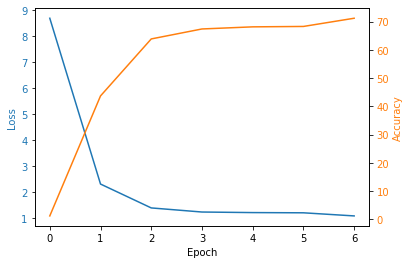

loss: 1.045044  [    0/25000] epoch: 7
loss: 1.484346  [ 3200/25000] epoch: 7
loss: 1.728774  [ 6400/25000] epoch: 7
loss: 1.589201  [ 9600/25000] epoch: 7
loss: 1.432459  [12800/25000] epoch: 7
loss: 0.594451  [16000/25000] epoch: 7
loss: 1.014873  [19200/25000] epoch: 7
loss: 1.819075  [22400/25000] epoch: 7
Epoch: 7
Test Error: 
 Accuracy: 71.2%, Avg loss: 1.091422 



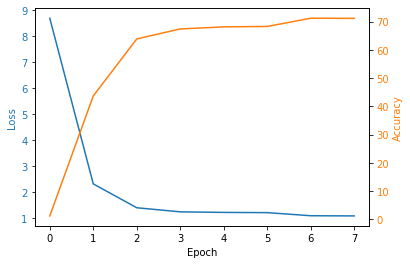

loss: 1.298224  [    0/25000] epoch: 8
loss: 0.693885  [ 3200/25000] epoch: 8
loss: 1.286259  [ 6400/25000] epoch: 8
loss: 1.419022  [ 9600/25000] epoch: 8
loss: 1.515553  [12800/25000] epoch: 8
loss: 1.219919  [16000/25000] epoch: 8
loss: 0.890852  [19200/25000] epoch: 8
loss: 1.270360  [22400/25000] epoch: 8
Epoch: 8
Test Error: 
 Accuracy: 71.2%, Avg loss: 1.120973 



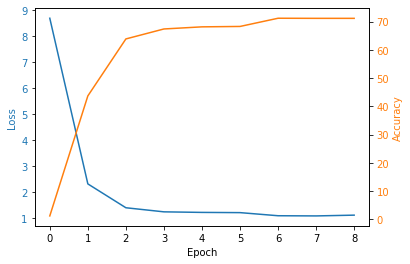

loss: 1.606529  [    0/25000] epoch: 9
loss: 1.341072  [ 3200/25000] epoch: 9
loss: 0.673034  [ 6400/25000] epoch: 9
loss: 1.759854  [ 9600/25000] epoch: 9
loss: 1.376012  [12800/25000] epoch: 9
loss: 0.927629  [16000/25000] epoch: 9
loss: 0.664937  [19200/25000] epoch: 9
loss: 1.356086  [22400/25000] epoch: 9
Epoch: 9
Test Error: 
 Accuracy: 71.7%, Avg loss: 1.114404 



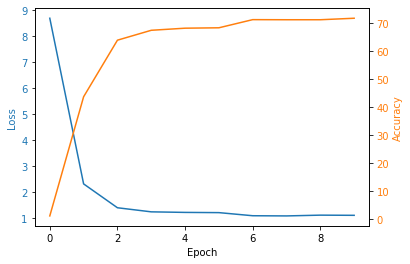

loss: 1.024968  [    0/25000] epoch: 10
loss: 1.357584  [ 3200/25000] epoch: 10
loss: 0.977551  [ 6400/25000] epoch: 10
loss: 1.698835  [ 9600/25000] epoch: 10
loss: 1.383335  [12800/25000] epoch: 10
loss: 0.829482  [16000/25000] epoch: 10
loss: 0.827786  [19200/25000] epoch: 10
loss: 1.390242  [22400/25000] epoch: 10
Epoch: 10
Test Error: 
 Accuracy: 71.2%, Avg loss: 1.116758 



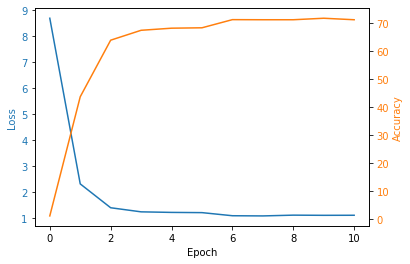

loss: 1.209093  [    0/25000] epoch: 11
loss: 1.020151  [ 3200/25000] epoch: 11
loss: 0.871486  [ 6400/25000] epoch: 11
loss: 1.488405  [ 9600/25000] epoch: 11
loss: 1.365326  [12800/25000] epoch: 11
loss: 1.243830  [16000/25000] epoch: 11
loss: 1.205958  [19200/25000] epoch: 11
loss: 1.851780  [22400/25000] epoch: 11
Epoch: 11
Test Error: 
 Accuracy: 71.1%, Avg loss: 1.124071 



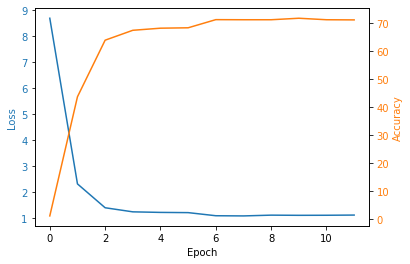

loss: 0.891465  [    0/25000] epoch: 12
loss: 0.733779  [ 3200/25000] epoch: 12
loss: 0.955148  [ 6400/25000] epoch: 12
loss: 1.713561  [ 9600/25000] epoch: 12
loss: 1.151439  [12800/25000] epoch: 12
loss: 1.236926  [16000/25000] epoch: 12
loss: 1.799048  [19200/25000] epoch: 12
loss: 0.631947  [22400/25000] epoch: 12
Epoch: 12
Test Error: 
 Accuracy: 71.8%, Avg loss: 1.094846 



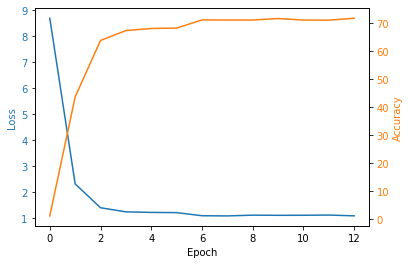

loss: 1.056298  [    0/25000] epoch: 13
loss: 1.485679  [ 3200/25000] epoch: 13
loss: 0.887825  [ 6400/25000] epoch: 13
loss: 1.095116  [ 9600/25000] epoch: 13
loss: 0.462505  [12800/25000] epoch: 13
loss: 0.854291  [16000/25000] epoch: 13
loss: 0.573810  [19200/25000] epoch: 13
loss: 0.396889  [22400/25000] epoch: 13
Epoch: 13
Test Error: 
 Accuracy: 72.5%, Avg loss: 1.117096 



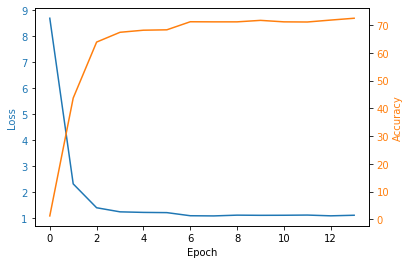

loss: 1.204587  [    0/25000] epoch: 14
loss: 1.831000  [ 3200/25000] epoch: 14
loss: 0.805750  [ 6400/25000] epoch: 14
loss: 0.678831  [ 9600/25000] epoch: 14
loss: 1.328433  [12800/25000] epoch: 14
loss: 1.097792  [16000/25000] epoch: 14
loss: 0.435178  [19200/25000] epoch: 14
loss: 0.695109  [22400/25000] epoch: 14
Epoch: 14
Test Error: 
 Accuracy: 71.1%, Avg loss: 1.153767 



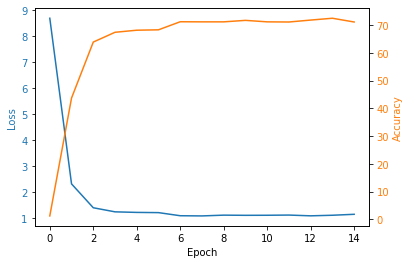

loss: 1.376584  [    0/25000] epoch: 15
loss: 0.304499  [ 3200/25000] epoch: 15
loss: 1.089516  [ 6400/25000] epoch: 15
loss: 0.784915  [ 9600/25000] epoch: 15
loss: 1.976799  [12800/25000] epoch: 15
loss: 0.505446  [16000/25000] epoch: 15
loss: 0.562344  [19200/25000] epoch: 15
loss: 0.768103  [22400/25000] epoch: 15
Epoch: 15
Test Error: 
 Accuracy: 71.0%, Avg loss: 1.156043 



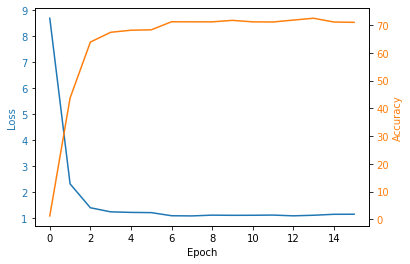

loss: 0.601521  [    0/25000] epoch: 16
loss: 0.694311  [ 3200/25000] epoch: 16
loss: 1.100944  [ 6400/25000] epoch: 16
loss: 0.764676  [ 9600/25000] epoch: 16
loss: 0.609409  [12800/25000] epoch: 16
loss: 0.408940  [16000/25000] epoch: 16
loss: 1.222911  [19200/25000] epoch: 16
loss: 0.570539  [22400/25000] epoch: 16
Epoch: 16
Test Error: 
 Accuracy: 72.0%, Avg loss: 1.143590 



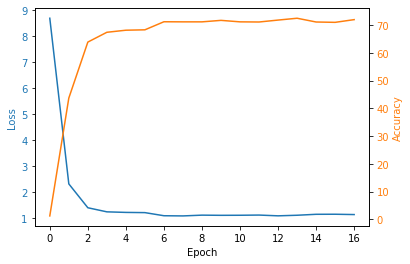

loss: 1.071076  [    0/25000] epoch: 17


KeyboardInterrupt: 

In [12]:
stats = train_loop(trainloader, beit, criterion, optimizer)

In [13]:
# PATH = './transfered_beit.pth'
# torch.save(beit.state_dict(), PATH)

beit.load_state_dict(torch.load("../../other_beit_optimal.pth"))
beit.to(device)

BeitForImageClassification(
  (beit): BeitModel(
    (embeddings): BeitEmbeddings(
      (patch_embeddings): PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): BeitEncoder(
      (layer): ModuleList(
        (0): BeitLayer(
          (attention): BeitAttention(
            (attention): BeitSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (relative_position_bias): BeitRelativePositionBias()
            )
            (output): BeitSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (interme

In [18]:
test_results = {"img_name" : [], "label": []}

for file_name, image in tqdm(testloader):
    X = image.to(device)
    pred = beit(X)["logits"].argmax(1)
    
    test_results["img_name"] += file_name
    test_results["label"] += [int(i) for i in pred.cpu()]

100%|████████████████████████████████████████| 479/479 [02:40<00:00,  2.98it/s]


In [19]:
test_df = pd.DataFrame(test_results)

test_df.head()

,img_name,label
0,test_1.jpg,15
1,test_10.jpg,45
2,test_100.jpg,75
3,test_1000.jpg,29
4,test_1001.jpg,18


In [20]:
test_df.to_csv("../../submission_beit_other.csv", index=False)